## Classification model with DistilBert Embeddings 

This model is fine tuned on Distilbert Architecture 

##### *Loading packages and Libraries*

In [1]:
#!pip install transformers

In [2]:
#!pip install codecarbon

In [36]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
import tensorflow as tf
import pandas as pd
import json
import os 
import xlrd
import matplotlib.pyplot as plt

from codecarbon import EmissionsTracker

#### *Reading the data*

Here we are loading the data from shared drive

In [3]:
df = pd.read_excel('annotations.xlsx')
print(df)

       Unnamed: 0  Unnamed: 0.1                  survey_record_id  \
0               0         19227  0045473f40ec42a2bd2ca0ee35df0b75   
1               1         19228  0045473f40ec42a2bd2ca0ee35df0b75   
2               2         19229  0045473f40ec42a2bd2ca0ee35df0b75   
3               3         19231  0045473f40ec42a2bd2ca0ee35df0b75   
4               4         19232  0045473f40ec42a2bd2ca0ee35df0b75   
...           ...           ...                               ...   
17770       22466         18746  ffb744b78ce2471cbc1ead6be531fc84   
17771       22467         18748  ffb744b78ce2471cbc1ead6be531fc84   
17772       22468         18749  ffb744b78ce2471cbc1ead6be531fc84   
17773       22469         18753  ffb744b78ce2471cbc1ead6be531fc84   
17774       22470         18755  ffb744b78ce2471cbc1ead6be531fc84   

                            sentence_id  sentence_group_id  \
0      06e9e57e549d4dd48d8ac649ff81fd2e                 67   
1      07f2137fd3ae4dd2b5c990b93e5c2a62        

In [4]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'survey_record_id', 'sentence_id',
       'sentence_group_id', 'created_at', 'label', 'words', 'factual',
       'group_id', 'text', 'link', 'type', 'topic', 'outlet', 'mturk_id',
       'age', 'gender', 'education', 'native_english_speaker',
       'political_ideology', 'followed_news_outlets', 'news_check_frequency',
       'survey_completed'],
      dtype='object')

#### *Data Manipulation*

In [5]:
# filtering required columns
df = df[['label', 'words', 'factual', 'text', 'topic']]
df = df.dropna(subset=['text', 'label'])
df.head()

,label,words,factual,text,topic
0,Non-biased,NaN,Entirely factual,The transgender effort to suppress any recogni...,gender
1,Non-biased,NaN,Expresses writer’s opinion,Radical Virginia Citizens Defense League has o...,gun-control
2,Non-biased,NaN,Somewhat factual but also opinionated,Miller is the architect of President Donald Tr...,white-nationalism
3,Non-biased,NaN,Expresses writer’s opinion,"The House Democrats’ 1,400-page coronavirus re...",coronavirus
4,Non-biased,NaN,Expresses writer’s opinion,A specter is haunting the West; our elites see...,white-nationalism


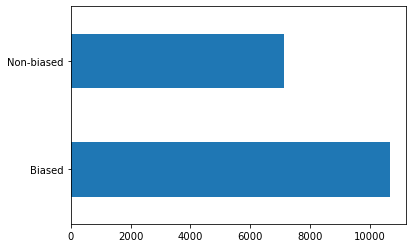

In [6]:
df['label'].value_counts().plot(kind='barh')

In [88]:
df['label'].value_counts()

Biased        10651
Non-biased     7124
Name: label, dtype: int64

In [7]:
df['encoded Label'] = df['label']
df.replace({'encoded Label': {'Non-biased': 0, 'Biased': 1}}, inplace=True)

#### *Features and Labels*

In [8]:
data_texts = df["text"].to_list() # Features (not-tokenized yet)
data_labels = df["encoded Label"].to_list() # Lables

#### *Splitting data to train and test*

In [9]:
from sklearn.model_selection import train_test_split

# Split Train and Validation data
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.10, random_state=0)

# Keep some data for inference (testing)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.10, random_state=0)

#### *tokenizing the text*

In [10]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', cuda = 0)
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

#### *Datset object for Tensorflow*

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

#### *Model definition*

In [13]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [14]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  1538      
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


#### *Traning the Model*

In [15]:
tracker = EmissionsTracker()
tracker.start()

history = model.fit(train_dataset.shuffle(1000).batch(16), epochs=30, batch_size=16,
                    validation_data=val_dataset.shuffle(1000).batch(16))

tracker.stop()

CODECARBON : No CPU tracking mode found. Falling back on CPU constant mode.
CODECARBON : Failed to match CPU TDP constant. Falling back on a global constant.


Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fca0bc03048> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fca0bc03048> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

900/900 [==============================] - 355s 377ms/step - loss: 0.6169 - accuracy: 0.6614 - val_loss: 0.6471 - val_accuracy: 0.6631
Epoch 2/30
900/900 [==============================] - 339s 376ms/step - loss: 0.5755 - accuracy

0.31935524513626445

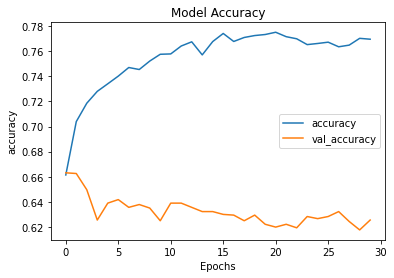

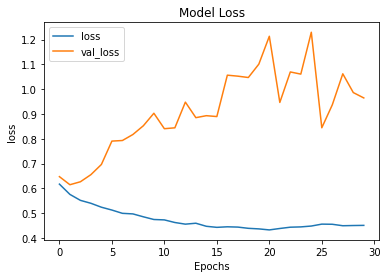

In [53]:
# plotting the results
def plot_graphs(history, metric, title):
  plt.plot(history.history[metric])
  plt.title(title)
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

plot_graphs(history, 'accuracy', 'Model Accuracy')
plot_graphs(history, 'loss', 'Model Loss')

#### *Save the Model in working directory*


In [18]:
save_directory = './model'

In [19]:
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('./model/tokenizer_config.json',
 './model/special_tokens_map.json',
 './model/vocab.txt',
 './model/added_tokens.json')


#### *Loading the Model*

In [20]:
save_directory = './model'

In [21]:
loaded_tokenizer = DistilBertTokenizer.from_pretrained(save_directory)
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

Some layers from the model checkpoint at ./model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./model and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### *Testing on Custom Data*

In [27]:
def prediction(test_text):
    predict_input = loaded_tokenizer.encode(test_text,
                                    truncation=True,
                                    padding=True,
                                    return_tensors="tf")

    output = loaded_model(predict_input)[0]

    prediction_value = tf.argmax(output, axis=1).numpy()[0]
    
    if (prediction_value == 1):
        label = "Biased"
    elif (prediction_value == 0):
        label = 'Non-biased'
    
    return label

In [34]:
#test_text = "men are highly talented than women in many skills"
test_text = "There was an attack in Mali by a group of people"
prediction(test_text)

'Non-biased'

#### *Classification Metrics*

In [64]:
def prediction(test_text):
    predict_input = loaded_tokenizer.encode(test_text,
                                    truncation=True,
                                    padding=True,
                                    return_tensors="tf")

    output = loaded_model(predict_input)[0]

    prediction_value = tf.argmax(output, axis=1).numpy()[0]

    return prediction_value

In [66]:
preds = []
for text in val_texts:
    predicted = prediction(text)
    preds.append(predicted)

In [81]:
from sklearn.metrics import classification_report

print(classification_report(val_labels, preds))

              precision    recall  f1-score   support

           0       0.54      0.54      0.54       724
           1       0.68      0.68      0.68      1054

    accuracy                           0.63      1778
   macro avg       0.61      0.61      0.61      1778
weighted avg       0.63      0.63      0.63      1778

